# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [1]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

/Users/zhayaqi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [3]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [4]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [5]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implemen-
tation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [6]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        # Aggregation
        if graph_aggregation_method == "sum":
            output = torch.sum(H2, dim=0)
        elif graph_aggregation_method == "mean":
            output = torch.mean(H2, dim=0)
        elif graph_aggregation_method == "max":
            output, _ = torch.max(H2, dim=0)
        else:
            raise ValueError("Invalid aggregation method.")

        output = torch.sigmoid(output)

        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, H1, H2
        else:
            return output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [7]:
# Preparing the Basics:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)


In [8]:
# Training the model
random.shuffle(train_data)

# Initialize a list to store loss values for visualization
loss_values = {}

# Training
num_epochs = 10
aggregation_methods = ["sum", "mean", "max"]

for method in aggregation_methods:
    print(f"\nAggregation Method: {method}")
    loss_values[method] = [] 

    for epoch in range(num_epochs):
    # Train without returning embeddings for other epochs
    #note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.
    
    # ####################################################
    # MODIFY THE CODE BELOW 
    #  (note only aggregation param - and make sure to run all of them)
    # ####################################################    
        loss = train_epoch(model, train_data, optimizer, criterion, graph_aggregation_method=method)


    # ####################################################
    # END OF MODIFICATION
    # ####################################################   
        print(f"Epoch {epoch+1}, Loss: {loss}")
        loss_values[method].append(loss)


Aggregation Method: sum
Epoch 1, Loss: 11.761040058461207
Epoch 2, Loss: 11.494641369326459
Epoch 3, Loss: 10.611822392573034
Epoch 4, Loss: 9.868570692630255
Epoch 5, Loss: 7.857204919432533
Epoch 6, Loss: 7.339391693529175
Epoch 7, Loss: 5.83076531946746
Epoch 8, Loss: 5.023726743228981
Epoch 9, Loss: 4.556071158469781
Epoch 10, Loss: 3.8090273537059876

Aggregation Method: mean
Epoch 1, Loss: 0.5654077104603251
Epoch 2, Loss: 0.5543344163646301
Epoch 3, Loss: 0.5461803009790002
Epoch 4, Loss: 0.540065955822215
Epoch 5, Loss: 0.5352870107656627
Epoch 6, Loss: 0.5313450057680408
Epoch 7, Loss: 0.5278068571774797
Epoch 8, Loss: 0.5244701971074172
Epoch 9, Loss: 0.5212227450119276
Epoch 10, Loss: 0.5180482833194687

Aggregation Method: max
Epoch 1, Loss: 0.4286472208080919
Epoch 2, Loss: 0.4089575559165413
Epoch 3, Loss: 0.40146388668235333
Epoch 4, Loss: 0.39616935595051583
Epoch 5, Loss: 0.39129113050876185
Epoch 6, Loss: 0.38504240784889343
Epoch 7, Loss: 0.3783471969981099
Epoch 8,

In [9]:
# Evaluate the model on the test set
true_labels, predicted_labels, accuracy = test(model, eval_data)

# Debug: Print true and predicted labels
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Calculate precision, recall (sensitivity), and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Accuracy: 0.5667
Precision: 0.5694
Recall: 0.5667
F1-score: 0.5623


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [10]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title=None):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"x_label")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'b-', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    if not title:
        title = f'Training Accuracy and Validation Accuracy Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [11]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

f1_scores_list = {}

def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose):
    """Trains the model and records loss and validation accuracy
    Should return, train_losses, train_accuracy, validation_accuracy
    """
    train_loss = []
    train_accuracy = []
    validation_accuracy = []
    train_f1_scores = []
    eval_f1_scores = []

    for epoch in range(epochs):
        # Train the model
        loss = train_epoch(model, train_dataset, optimizer, criterion, graph_aggregation_method=graph_aggregation_method)
        train_loss.append(loss)

        # Evaluate on training set
        true_train_labels, predicted_train_labels, train_acc = test(model, train_dataset)
        train_f1 = f1_score(true_train_labels, predicted_train_labels, average="macro")
        
        # Store results
        train_accuracy.append(train_acc)
        train_f1_scores.append(train_f1)

        # Evaluate on validation set
        true_eval_labels, predicted_eval_labels, val_acc = test(model, validation_dataset)
        val_f1 = f1_score(true_eval_labels, predicted_eval_labels, average="macro")
        
        # Store results
        validation_accuracy.append(val_acc)
        eval_f1_scores.append(val_f1)

        # Print results if verbose mode is enabled
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    f1_scores_list[method] = (train_f1_scores, eval_f1_scores)

    return train_loss, train_accuracy, validation_accuracy
    # # INCLUDE THiS STATEMENT IN YOUR CODE
    # if verbose:
    #     print(f"Epoch {epoch+1}, Training Loss: {loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc:.4f}")



# ####################################################
# END OF MODIFICATION
# ####################################################  


Aggregation Method: sum
Epoch 1, Training Loss: 68.6007, Train Accuracy: 0.2348, Validation Accuracy: 0.4833
Epoch 2, Training Loss: 63.0684, Train Accuracy: 0.2576, Validation Accuracy: 0.4000
Epoch 3, Training Loss: 36.6795, Train Accuracy: 0.5833, Validation Accuracy: 0.5500
Epoch 4, Training Loss: 22.6399, Train Accuracy: 0.6667, Validation Accuracy: 0.5167
Epoch 5, Training Loss: 19.4330, Train Accuracy: 0.7235, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 18.6715, Train Accuracy: 0.7386, Validation Accuracy: 0.5167
Epoch 7, Training Loss: 17.6967, Train Accuracy: 0.7386, Validation Accuracy: 0.5167
Epoch 8, Training Loss: 17.3616, Train Accuracy: 0.7462, Validation Accuracy: 0.5167
Epoch 9, Training Loss: 16.1452, Train Accuracy: 0.7462, Validation Accuracy: 0.5167
Epoch 10, Training Loss: 15.9999, Train Accuracy: 0.7538, Validation Accuracy: 0.5167


<Figure size 1000x600 with 0 Axes>

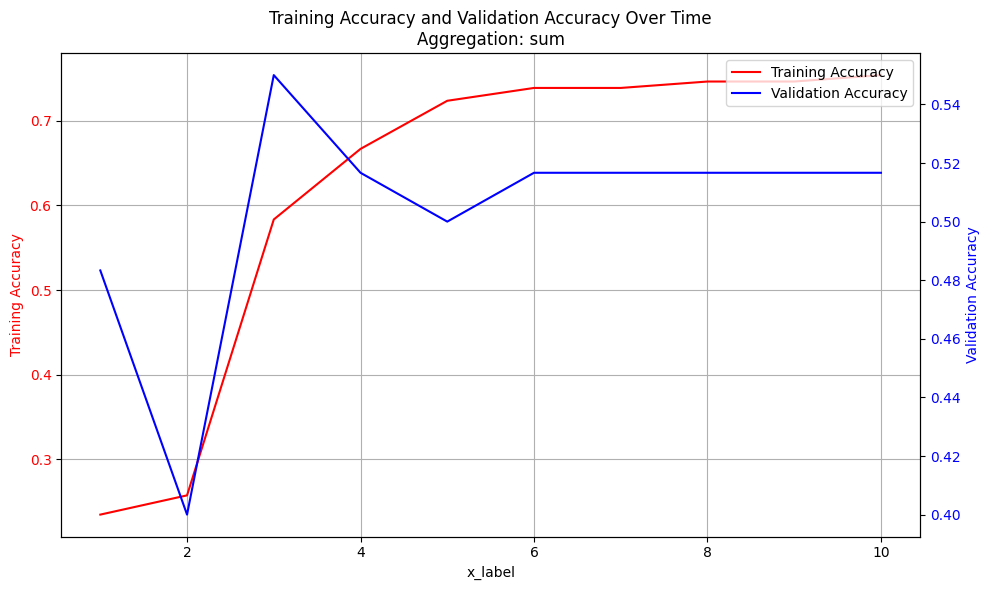


Aggregation Method: mean
Epoch 1, Training Loss: 1.7219, Train Accuracy: 0.5909, Validation Accuracy: 0.6000
Epoch 2, Training Loss: 0.6416, Train Accuracy: 0.7652, Validation Accuracy: 0.5667
Epoch 3, Training Loss: 0.5688, Train Accuracy: 0.7576, Validation Accuracy: 0.5500
Epoch 4, Training Loss: 0.5428, Train Accuracy: 0.7652, Validation Accuracy: 0.5333
Epoch 5, Training Loss: 0.5249, Train Accuracy: 0.7765, Validation Accuracy: 0.5667
Epoch 6, Training Loss: 0.5118, Train Accuracy: 0.7879, Validation Accuracy: 0.5500
Epoch 7, Training Loss: 0.5020, Train Accuracy: 0.8030, Validation Accuracy: 0.5500
Epoch 8, Training Loss: 0.4947, Train Accuracy: 0.8106, Validation Accuracy: 0.5500
Epoch 9, Training Loss: 0.4890, Train Accuracy: 0.8144, Validation Accuracy: 0.5500
Epoch 10, Training Loss: 0.4844, Train Accuracy: 0.8144, Validation Accuracy: 0.5667


<Figure size 1000x600 with 0 Axes>

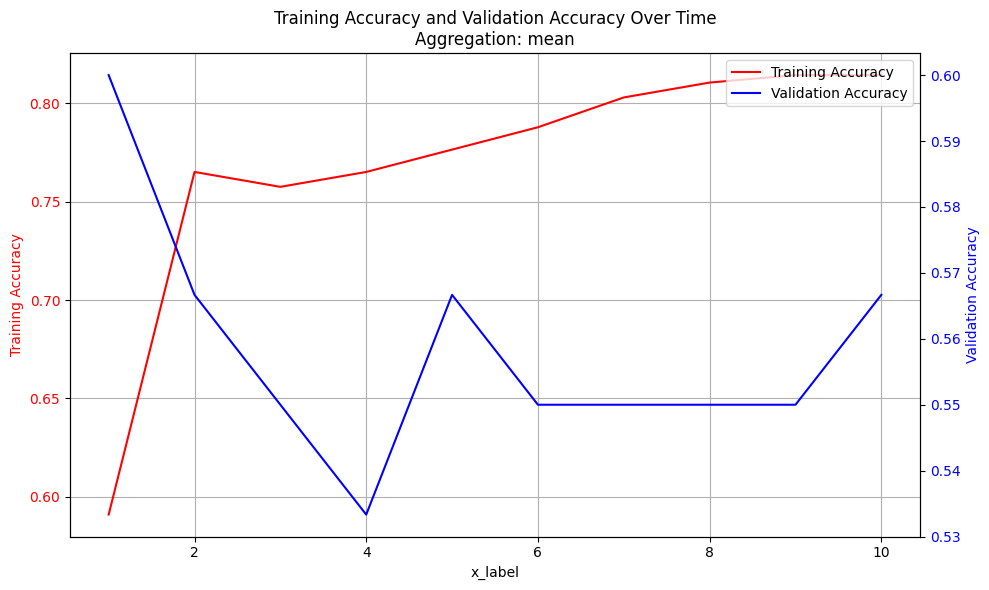


Aggregation Method: max
Epoch 1, Training Loss: 0.4828, Train Accuracy: 0.5833, Validation Accuracy: 0.4167
Epoch 2, Training Loss: 0.4695, Train Accuracy: 0.5758, Validation Accuracy: 0.3833
Epoch 3, Training Loss: 0.4594, Train Accuracy: 0.5985, Validation Accuracy: 0.3833
Epoch 4, Training Loss: 0.4504, Train Accuracy: 0.6061, Validation Accuracy: 0.4167
Epoch 5, Training Loss: 0.4426, Train Accuracy: 0.6477, Validation Accuracy: 0.4167
Epoch 6, Training Loss: 0.4344, Train Accuracy: 0.6439, Validation Accuracy: 0.4333
Epoch 7, Training Loss: 0.4245, Train Accuracy: 0.6364, Validation Accuracy: 0.4000
Epoch 8, Training Loss: 0.4117, Train Accuracy: 0.6250, Validation Accuracy: 0.4167
Epoch 9, Training Loss: 0.3981, Train Accuracy: 0.6326, Validation Accuracy: 0.4333
Epoch 10, Training Loss: 0.3869, Train Accuracy: 0.6364, Validation Accuracy: 0.4333


<Figure size 1000x600 with 0 Axes>

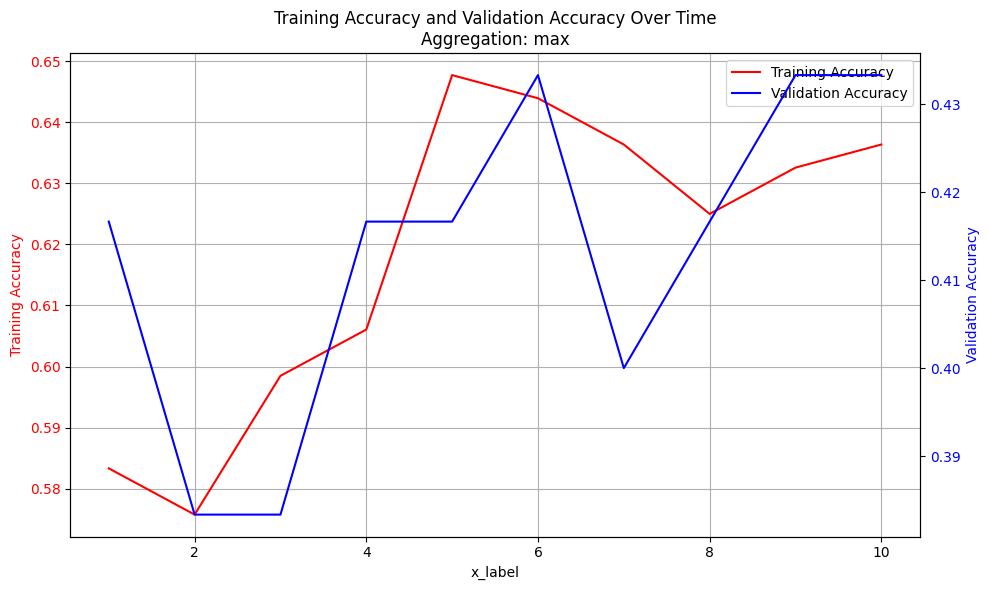

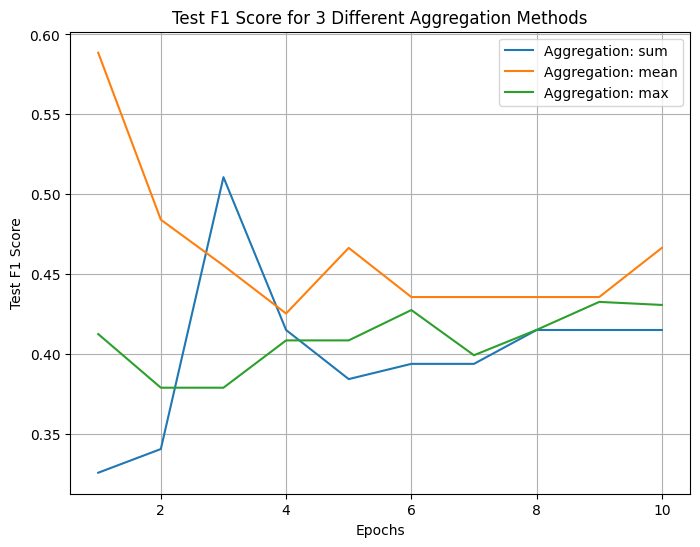

In [12]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8

aggregation_methods = ["sum", "mean", "max"]

# Store results for plotting
results = {}

# Train and evaluate for each aggregation method
for method in aggregation_methods:
    print(f"\nAggregation Method: {method}")

    # Initialization
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    #print(model)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses, train_acc, eval_acc = train_model(
    model, 
    optimizer, 
    criterion, 
    train_data, 
    eval_data, 
    epochs=num_epochs, 
    graph_aggregation_method=method,
    verbose=True
    )

    # Plot training acc vs evaluation acc
    plot_training_and_validation(train_acc, eval_acc, aggregation=method)


# Plot the test f1 for all three aggregation methods
plt.figure(figsize=(8,6))
for method in f1_scores_list.keys():
    _, eval_f1 = f1_scores_list[method]
    plt.plot(range(1, num_epochs+1), eval_f1, label=f"Aggregation: {method}")

plt.xlabel("Epochs")
plt.ylabel("Test F1 Score")
plt.title("Test F1 Score for 3 Different Aggregation Methods")
plt.legend()
plt.grid(True)
plt.show()

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?


F1-Scores Data (Training & Evaluation):

Aggregation Method: sum
Training F1-scores: [0.1932, 0.2435, 0.4919, 0.4806, 0.5154, 0.5162, 0.4865, 0.5013, 0.5115, 0.5162]
Evaluation F1-scores: [0.3258, 0.3407, 0.5107, 0.4151, 0.3844, 0.3939, 0.3939, 0.4151, 0.4151, 0.4151]

Aggregation Method: mean
Training F1-scores: [0.5472, 0.6288, 0.5714, 0.5773, 0.594, 0.6182, 0.6518, 0.6651, 0.6689, 0.6689]
Evaluation F1-scores: [0.5886, 0.4841, 0.4555, 0.4254, 0.4665, 0.4357, 0.4357, 0.4357, 0.4357, 0.4665]

Aggregation Method: max
Training F1-scores: [0.5435, 0.5329, 0.5533, 0.5593, 0.6002, 0.5947, 0.5861, 0.5744, 0.583, 0.5909]
Evaluation F1-scores: [0.4126, 0.379, 0.379, 0.4086, 0.4086, 0.4276, 0.3993, 0.4152, 0.4327, 0.4308]


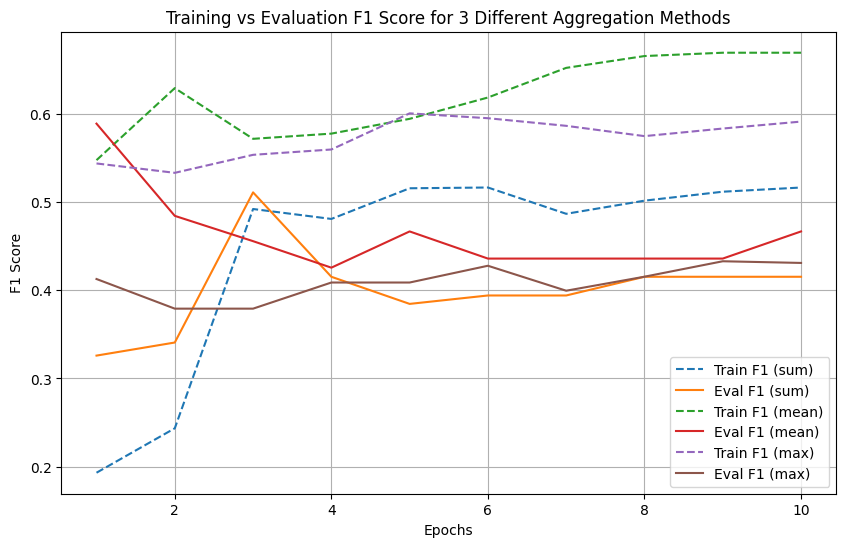

In [13]:
# Solution Q1.1.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# train_model()
# plot_training_and_validation()

# Print F1-score data
print("\nF1-Scores Data (Training & Evaluation):")
for method, (train_f1, eval_f1) in f1_scores_list.items():
    print(f"\nAggregation Method: {method}")
    print(f"Training F1-scores: {[round(score, 4) for score in train_f1]}")
    print(f"Evaluation F1-scores: {[round(score, 4) for score in eval_f1]}")

# Extract and plot F1-scores for each method
plt.figure(figsize=(10,6))
for method in f1_scores_list.keys():
    train_f1, eval_f1 = f1_scores_list[method]
    plt.plot(range(1, num_epochs+1), train_f1, linestyle="--", label=f"Train F1 ({method})")
    plt.plot(range(1, num_epochs+1), eval_f1, linestyle="-", label=f"Eval F1 ({method})")

# Plot the F1-score trends
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs Evaluation F1 Score for 3 Different Aggregation Methods")
plt.legend()
plt.grid(True)
plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################  


## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [14]:
# Helper function to visualise graphs:
def visualize_graph(G):
    """Visualize the generated graph."""
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True,
        node_size=500, font_size=8, font_color="white", edge_color="gray"
    )
    plt.title("Homogenous Graph Visualization")
    plt.show()

def visualise_graph_features(features_0, features_1):
    """plot clusters and their distribution"""
    plt.figure(figsize=(12, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take first feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.6, label='Class 0', color='red')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.6, label='Class 1', color='blue')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Class') 
    plt.title('Feature Distribution by Class')
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.legend()
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [15]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
from collections import Counter
def plot_class_distribution(labels):
    """Plots the distribution of labels"""
    plt.figure(figsize=(8, 5))
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.bar(unique_labels, counts, alpha=0.7)
    plt.xticks(unique_labels, ['Class 0', 'Class 1'])
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title("Class Label Distribution")
    plt.grid(axis="y")
    plt.show()


def plot_graph_topology(A):
    """Plots the graph topology"""
    G = nx.Graph(A.numpy())
    visualize_graph(G)

# ####################################################
# END OF MODIFICATION
# #################################################### 

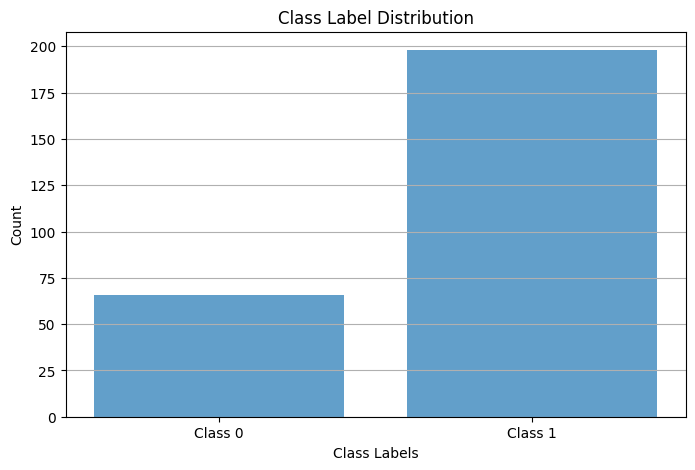

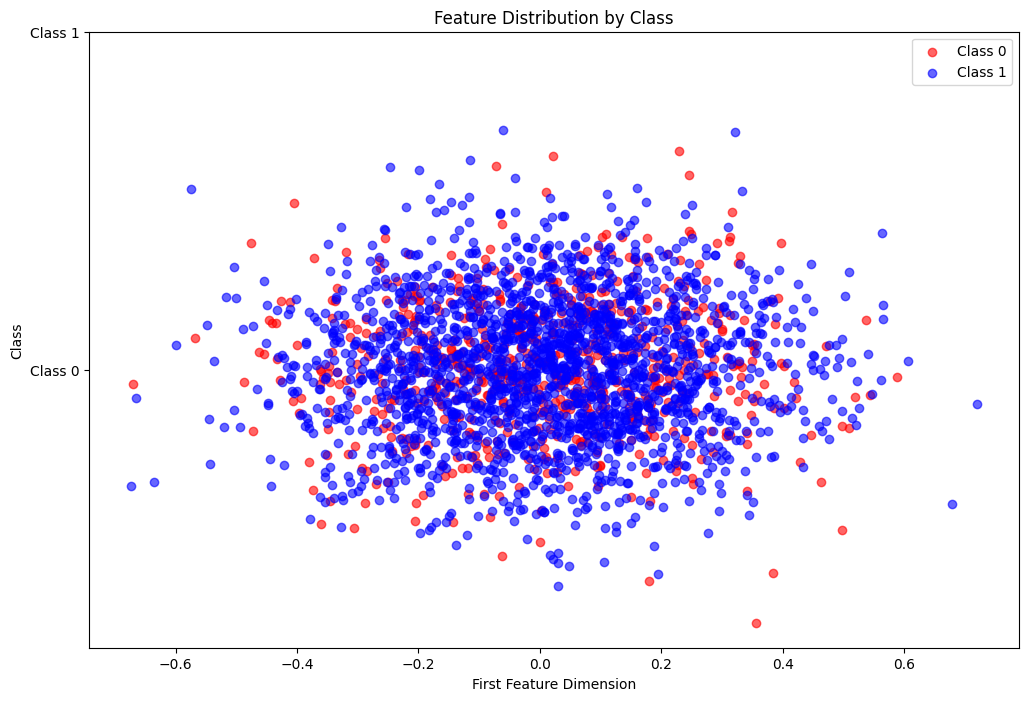

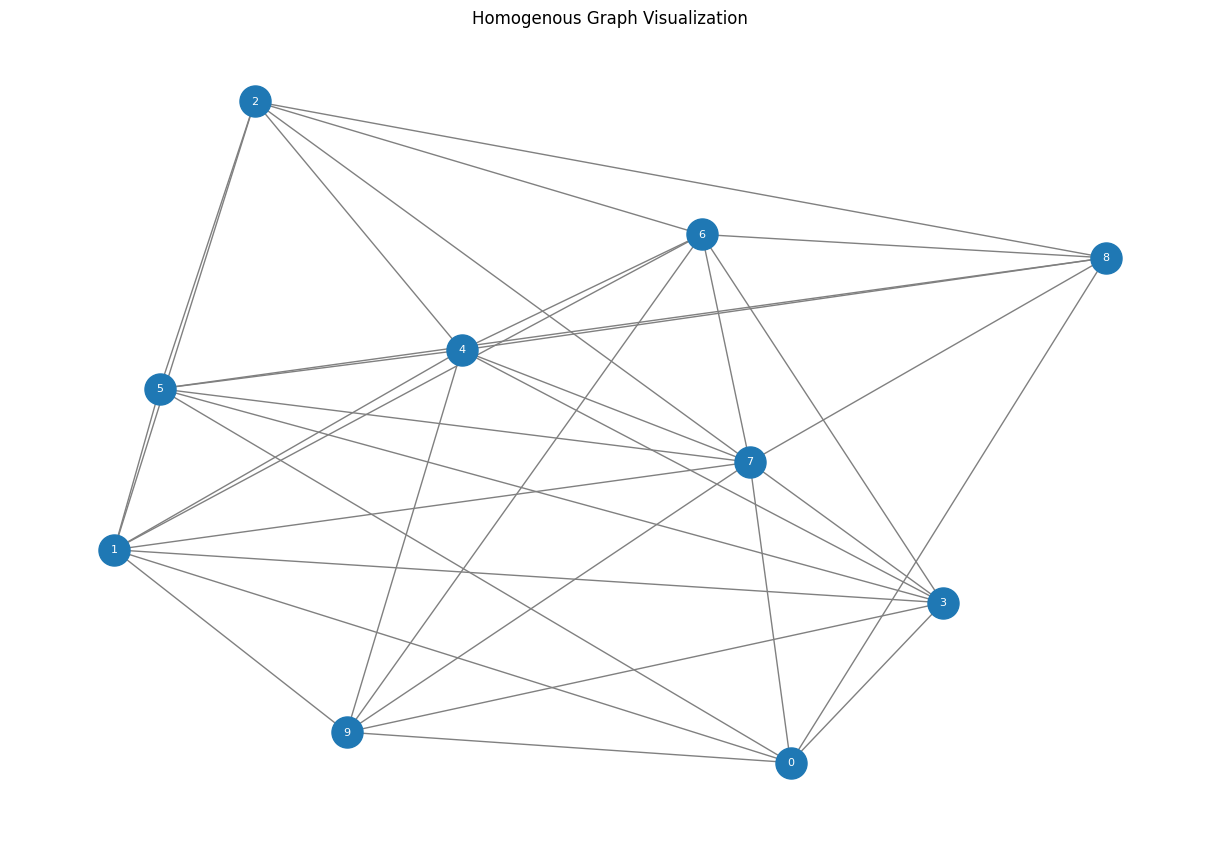

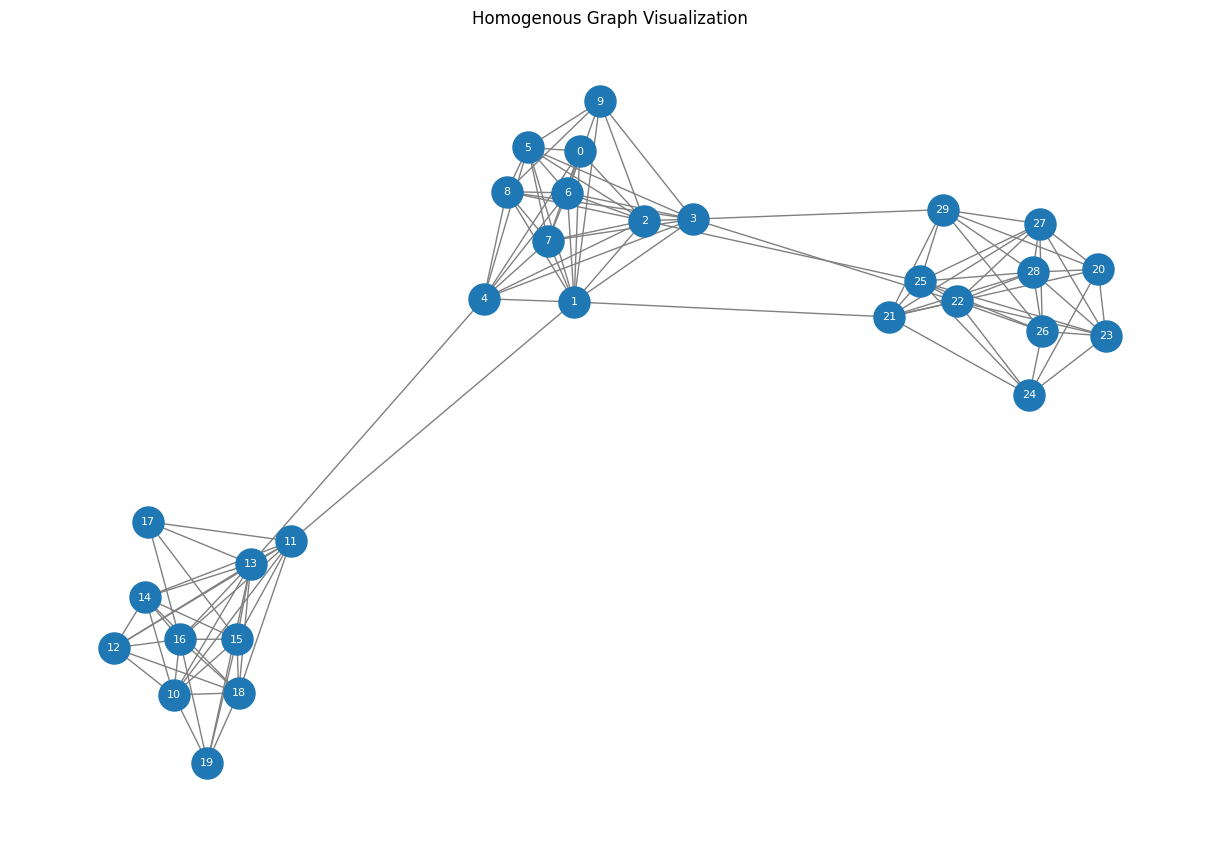

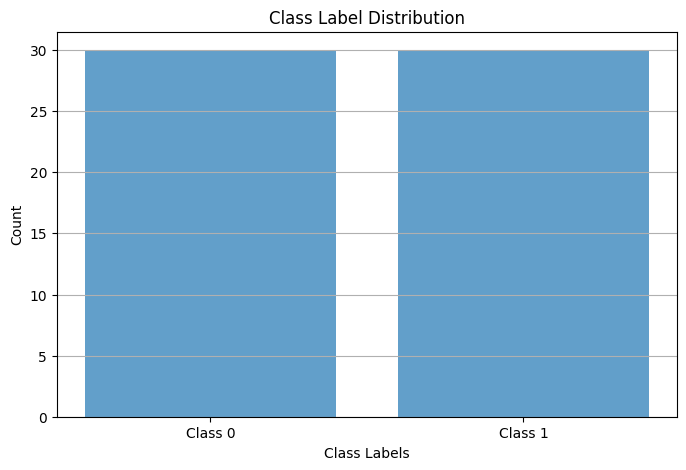

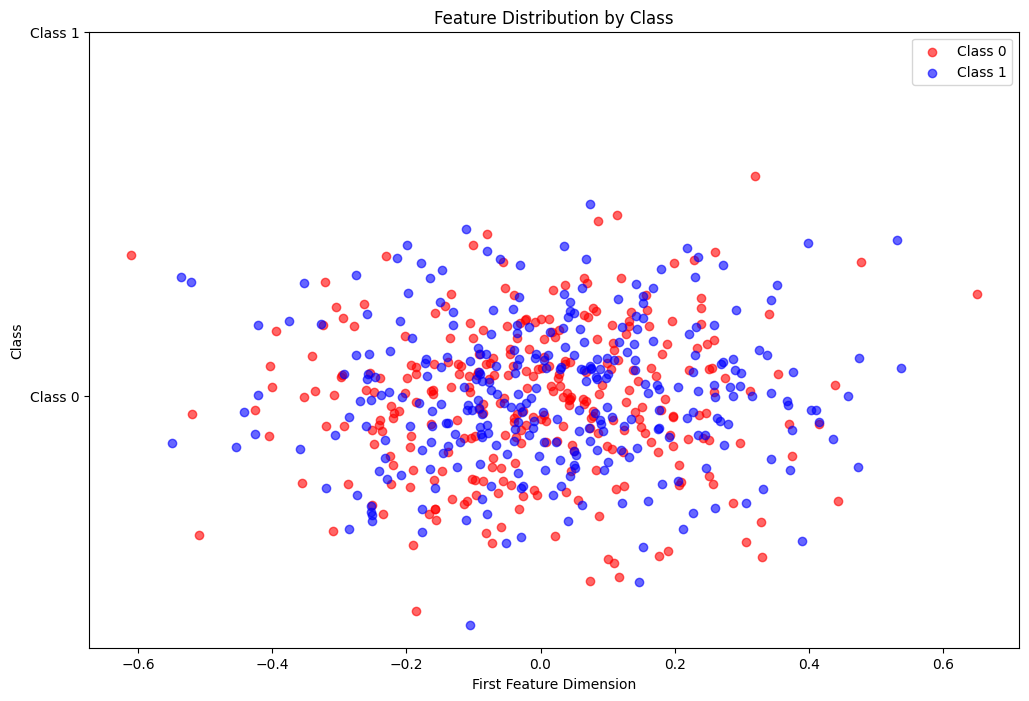

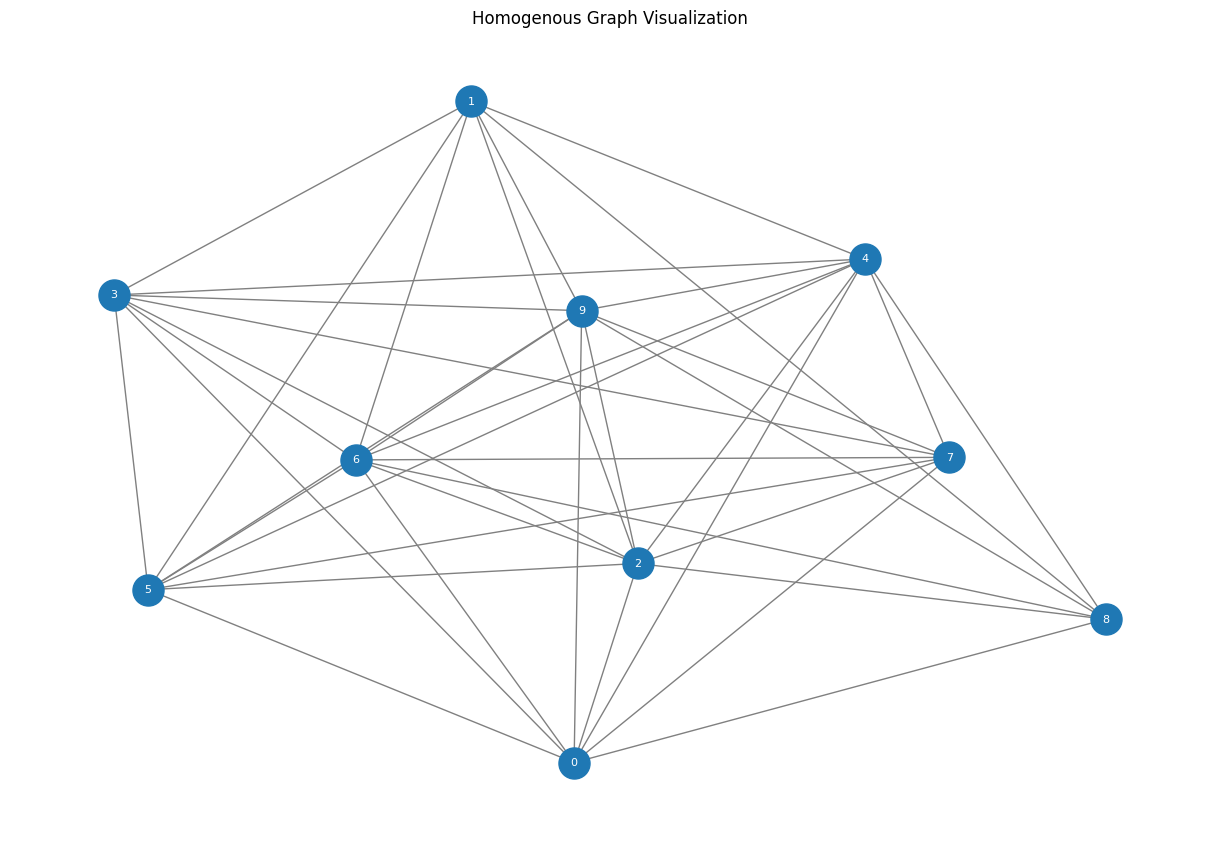

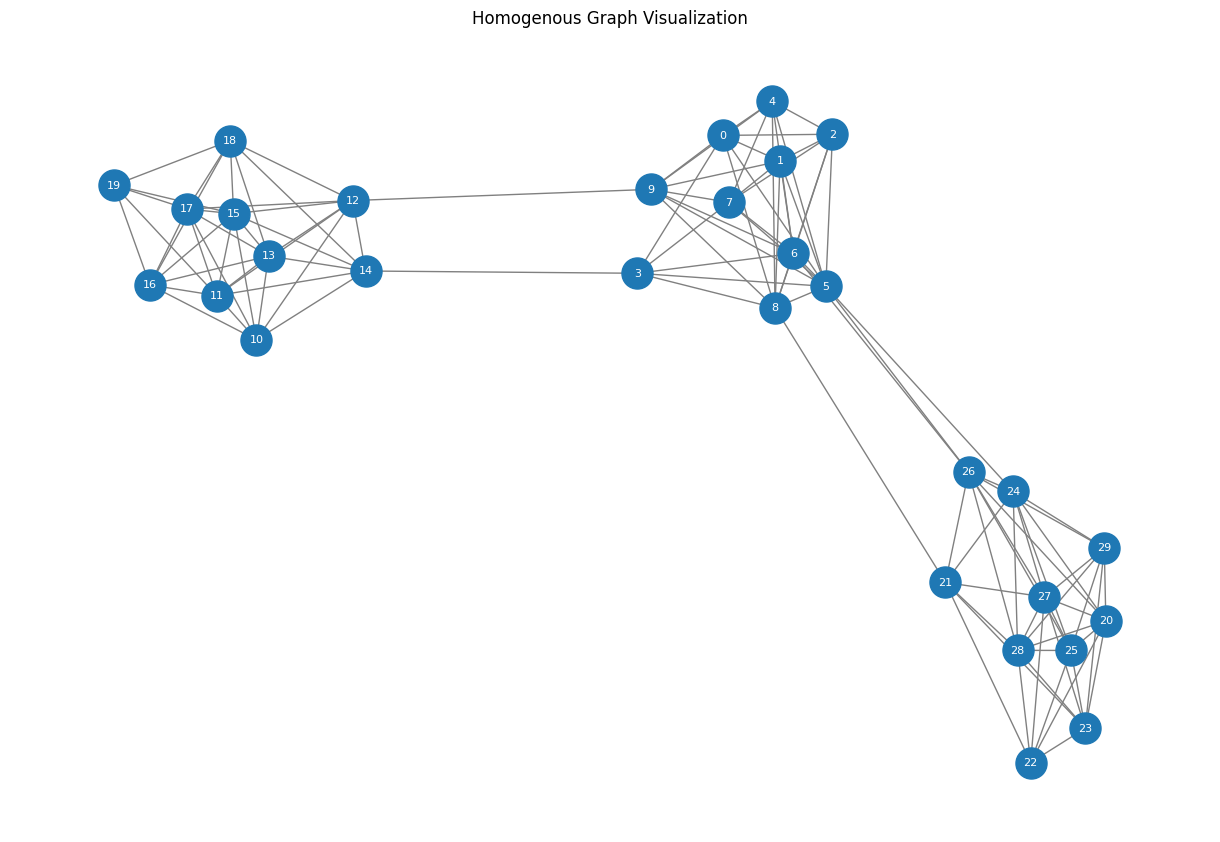

In [16]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval, A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
plot_class_distribution(train_labels)
visualise_graph_features(train_features_0, train_features_1)
plot_graph_topology(A0_train)
plot_graph_topology(A1_train)

# Plotting Eval
plot_class_distribution(eval_labels)
visualise_graph_features(eval_features_0, eval_features_1)
plot_graph_topology(A0_eval)
plot_graph_topology(A1_eval)



## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimen-
sion (i.e. the graph embedding dimension) as parametes. Experiment with different hyperparam-
eters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [17]:
# SOLUTION Q1.3.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer2(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1):
        super(MyGraphNeuralNetwork2, self).__init__()  
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(MyGCNLayer2(input_dim, hidden_dim, use_nonlinearity=True))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(MyGCNLayer2(hidden_dim, hidden_dim, use_nonlinearity=True))

        # Output layer
        self.layers.append(MyGCNLayer2(hidden_dim, output_dim, use_nonlinearity=False))
        self.classifier = nn.Linear(output_dim, 1)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        H = X
        for layer in self.layers:
            H = layer(H, A)

        # Aggregation
        if graph_aggregation_method == "sum":
            graph_embedding = torch.sum(H, dim=0)
        elif graph_aggregation_method == "mean":
            graph_embedding = torch.mean(H, dim=0)
        elif graph_aggregation_method == "max":
            graph_embedding, _ = torch.max(H, dim=0)
        else:
            raise ValueError("Invalid aggregation method.")
        
        graph_output = torch.sigmoid(self.classifier(graph_embedding))
        
        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################


Tuning with Hidden Dim: 8, Num Layers: 2
New Best Found: Hidden Dimension: 8, Num of Layers: 2, Val Accuracy: 0.7736

Tuning with Hidden Dim: 8, Num Layers: 3

Tuning with Hidden Dim: 8, Num Layers: 4
New Best Found: Hidden Dimension: 8, Num of Layers: 4, Val Accuracy: 0.7925

Tuning with Hidden Dim: 16, Num Layers: 2

Tuning with Hidden Dim: 16, Num Layers: 3

Tuning with Hidden Dim: 16, Num Layers: 4

Tuning with Hidden Dim: 32, Num Layers: 2
New Best Found: Hidden Dimension: 32, Num of Layers: 2, Val Accuracy: 0.8113

Tuning with Hidden Dim: 32, Num Layers: 3

Tuning with Hidden Dim: 32, Num Layers: 4


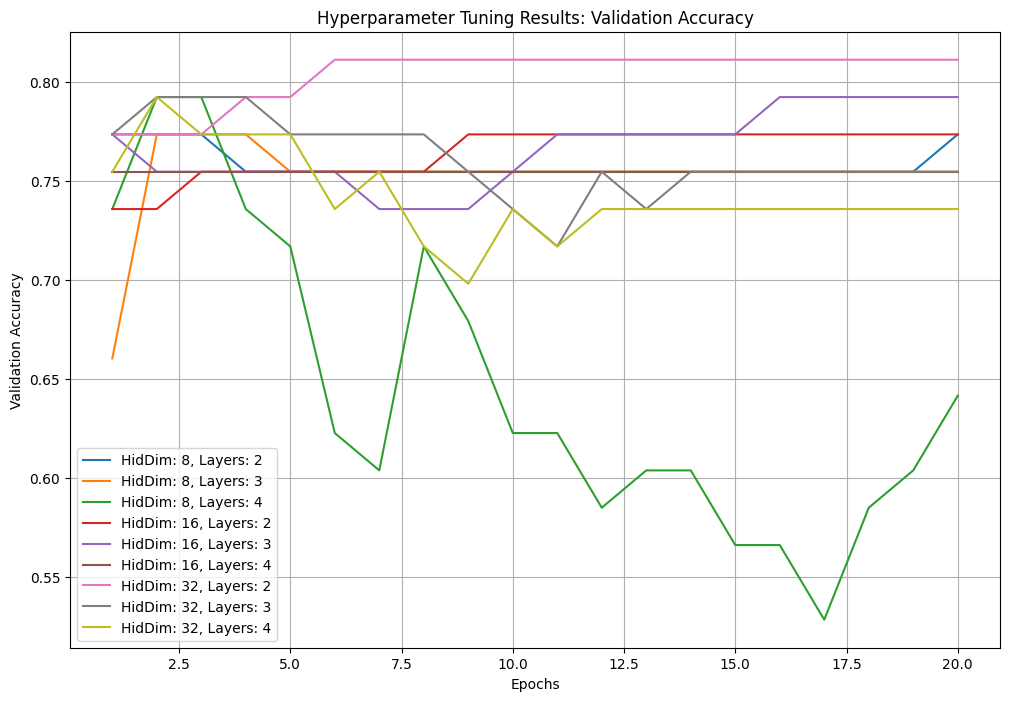

In [18]:
# Run different hyper params here
import random

def split_training_data(data, train_ratio=0.8):
    """Splits the dataset into training and validation sets"""
    # Shuffle the data
    random.shuffle(data)
    split_index = int(len(data) * train_ratio)
    
    # Split into training and validation sets
    train_data = data[:split_index]
    val_data = data[split_index:]
    
    return train_data, val_data


# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
output_dim = 8
num_epochs = 20

# Experiment with hyperparameters
hidden_dims = [8, 16, 32]
num_layers_list = [2, 3, 4]
results = {}
aggregation_method = "mean"

# Splitting the Data
train_data, val_data = split_training_data(train_data, 0.8)

best_hidden_dim = None
best_num_layers = None
best_val_acc = 0

# TRAIN
for hidden_dim in hidden_dims:
    for num_layers in num_layers_list:
        print(f"\nTuning with Hidden Dim: {hidden_dim}, Num Layers: {num_layers}")

        # Initialize Model
        model = MyGraphNeuralNetwork2(input_dim, hidden_dim, num_layers = num_layers, output_dim=output_dim)

        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_losses, train_acc, eval_acc = train_model(
            model,
            optimizer,
            criterion,
            train_data,
            val_data,
            epochs=num_epochs,
            graph_aggregation_method=aggregation_method,
            verbose=False
        )

        # Update
        max_val_acc = max(eval_acc)
        if max_val_acc > best_val_acc:
            best_val_acc = max_val_acc
            best_hidden_dim = hidden_dim
            best_num_layers = num_layers
            print(f"New Best Found: Hidden Dimension: {best_hidden_dim}, Num of Layers: {best_num_layers}, Val Accuracy: {best_val_acc:.4f}")


        results[(hidden_dim, num_layers)] = {
            "train_losses": train_losses,
            "train_acc": train_acc,
            "eval_acc": eval_acc
        } 

        # plot_training_and_validation(train_acc, eval_acc)


# Plot results
plt.figure(figsize=(12, 8))
for (hidden_dim, num_layers), acc_data in results.items():
    plt.plot(range(1, num_epochs+1), acc_data["eval_acc"], label=f"HidDim: {hidden_dim}, Layers: {num_layers}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning Results: Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

In [19]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

from sklearn.decomposition import PCA
import numpy as np
import random

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

def add_topology_features(data):
    """
    Adds node degree as a feature to the graph dataset.
    """
    for i, (X, A, y) in enumerate(data):
        degrees = torch.sum(A, dim=1).unsqueeze(1)
        X_augmented = torch.cat([X, degrees], dim=1)
        data[i] = (X_augmented, A, y)
    return data

# Add topology features
train_data = add_topology_features(train_data)
eval_data = add_topology_features(eval_data)

def apply_pca(train_data, eval_data, n_components=0.95):
    """
    Applies PCA to reduce feature dimensions while retaining 95% variance.
    """
    all_features = np.vstack([X.numpy() for X, _, _ in train_data])

    # Fit PCA on train_data
    pca = PCA(n_components=n_components)
    pca.fit(all_features)

    # Apply PCA to train and eval datasets
    def transform_data(data):
        transformed_data = []
        for X, A, y in data:
            X_pca = torch.tensor(pca.transform(X.numpy()), dtype=torch.float)
            transformed_data.append((X_pca, A, y))
        return transformed_data

    return transform_data(train_data), transform_data(eval_data)

# Apply PCA correctly
train_data, eval_data = apply_pca(train_data, eval_data)

def pad_graphs(graphs):
    """
    Pads adjacency and feature matrices to the largest graph size in the batch.
    """
    max_nodes = max(A.shape[0] for _, A, _ in graphs)

    padded_graphs = []
    for X, A, y in graphs:
        # Pad adjacency matrix
        A_padded = torch.zeros((max_nodes, max_nodes))
        A_padded[:A.shape[0], :A.shape[1]] = A

        # Pad feature matrix
        X_padded = torch.zeros((max_nodes, X.shape[1]))
        X_padded[:X.shape[0], :] = X

        padded_graphs.append((X_padded, A_padded, y))

    return padded_graphs

# Pad graphs
train_data = pad_graphs(train_data)
eval_data = pad_graphs(eval_data)

def balance_classes(dataset):
    '''Balances an imbalanced dataset by oversampling the minority class.'''
    # Separate graphs
    class_0 = [sample for sample in dataset if sample[2] == 0]
    class_1 = [sample for sample in dataset if sample[2] == 1]
    minor, major = (class_0, class_1) if len(class_0) < len(class_1) else (class_1, class_0)

    # Oversample
    while len(minor) < len(major):
        minor.append(random.choice(minor))

    balanced_data = major + minor

    # Shuffle
    random.shuffle(balanced_data)
    return balanced_data

# Balance data
train_data = balance_classes(train_data)
eval_data = balance_classes(eval_data)


class ImprovedGraphNeuralNetwork(nn.Module):
    """
    A GCN model with dropout to address overfitting.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=3, output_dim=1, dropout_rate=0.3):
        super(ImprovedGraphNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_rate)

        # Input layer
        self.layers.append(MyGCNLayer2(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(MyGCNLayer2(hidden_dim, hidden_dim))

        # Output layer
        self.layers.append(MyGCNLayer2(hidden_dim, output_dim, use_nonlinearity=False))

        self.classifier = nn.Linear(output_dim, 1)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        H = X
        for i in range(self.num_layers):
            H = self.layers[i](H, A) 
            H = self.dropout(H)
        
        # Aggregation
        if graph_aggregation_method == "sum":
            graph_embedding = torch.sum(H, dim=0)
        elif graph_aggregation_method == "mean":
            graph_embedding = torch.mean(H, dim=0)
        elif graph_aggregation_method == "max":
            graph_embedding, _ = torch.max(H, dim=0)
        else:
            raise ValueError("Invalid aggregation method.")

        graph_output = torch.sigmoid(self.classifier(graph_embedding))
        
        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output

# Parameters from previous Hyperparameter tuning
input_dim = train_data[0][0].shape[1]
hidden_dim = best_hidden_dim
num_layers = best_num_layers
dropout_rate = 0.5
num_epochs = 20
aggregation_methods = ["sum", "mean", "max"]
best_val_acc = 0
best_method = "sum"

train_data, val_data = split_training_data(train_data, 0.8)

# Hyperparameter tuning
for method in aggregation_methods:
    print(f"\nTesting Aggregation Method: {method}")

    # Initialization
    model = ImprovedGraphNeuralNetwork(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1, dropout_rate=0.3)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses, train_acc, val_acc = train_model(
        model,
        optimizer,
        criterion,
        train_data,
        val_data,
        epochs=num_epochs,
        graph_aggregation_method=method,
        verbose=False
    )

    # Update
    max_val_acc = max(val_acc)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_method = method
        print(f"New Best Found: Aggregation Medthod: {method} Val Accuracy: {best_val_acc:.4f}")
    
print(f"\nEnd of Hyperparameter tuning\n")


# Train the best model
train_losses, train_acc, val_acc = train_model(
    model,
    optimizer,
    criterion,
    train_data,
    val_data,
    epochs=num_epochs,
    graph_aggregation_method=best_method,
    verbose=False
)

# Evaluate the model on the test data
true_labels, predicted_labels, test_accuracy = test(model, eval_data)

# Visualize Test Accuracy
print(f"Final Test Accuracy on Best Model: {test_accuracy:.4f}")

# ####################################################
# END OF MODIFICATION
# ####################################################


Testing Aggregation Method: sum
New Best Found: Aggregation Medthod: sum Val Accuracy: 0.9375

Testing Aggregation Method: mean
New Best Found: Aggregation Medthod: mean Val Accuracy: 0.9750

Testing Aggregation Method: max

End of Hyperparameter tuning

Final Test Accuracy on Best Model: 0.9667


### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


Training Run 1/20
Training Run 2/20
Training Run 3/20
Training Run 4/20
Training Run 5/20
Training Run 6/20
Training Run 7/20
Training Run 8/20
Training Run 9/20
Training Run 10/20
Training Run 11/20
Training Run 12/20
Training Run 13/20
Training Run 14/20
Training Run 15/20
Training Run 16/20
Training Run 17/20
Training Run 18/20
Training Run 19/20
Training Run 20/20


<Figure size 1000x600 with 0 Axes>

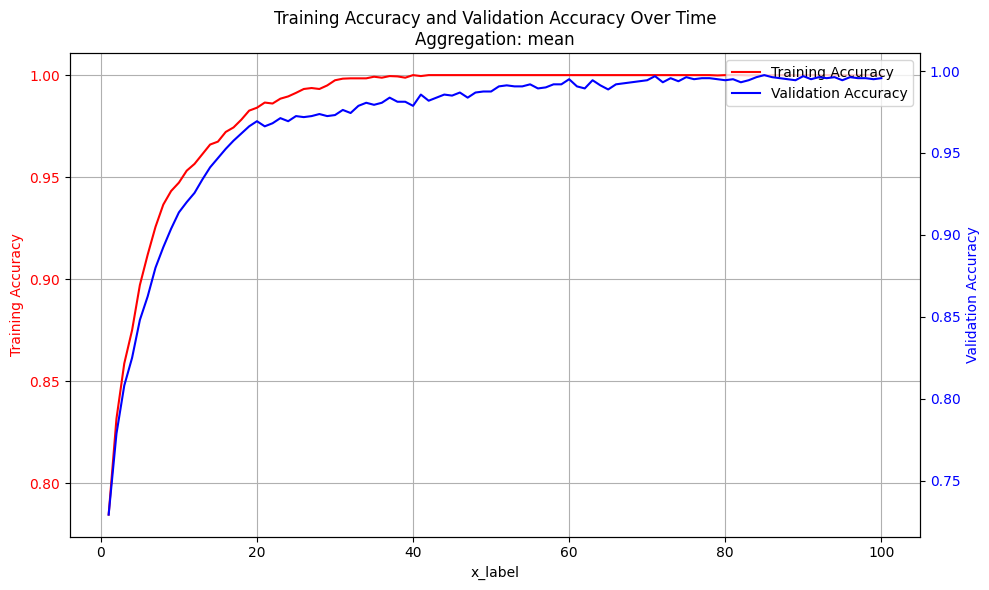

In [20]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

import matplotlib.pyplot as plt

num_epochs = 100
num_runs = 20

all_train_acc = np.zeros((num_runs, num_epochs))
all_val_acc = np.zeros((num_runs, num_epochs))

for run in range(num_runs):
    print(f"Training Run {run+1}/{num_runs}")

    model = ImprovedGraphNeuralNetwork(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses, train_acc, val_acc = train_model(
        model,
        optimizer,
        criterion,
        train_data,
        val_data,
        epochs=num_epochs,
        graph_aggregation_method=best_method,
        verbose=False
    )

    # Store results
    all_train_acc[run] = train_acc
    all_val_acc[run] = val_acc

# Compute average accuracy
averaged_train_acc = np.mean(all_train_acc, axis=0)
averaged_eval_acc = np.mean(all_val_acc, axis=0)

# Call this function in the end (with the averaged values)
plot_training_and_validation(averaged_train_acc, averaged_eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################